Equations:

P' = H * P (1)

- H: 3x3 homography matrix 
- P, P': equivalent points in two images

From turning (1) into system of equations and rearranging so = 0, we get Ah = 0
- h (9x1) is ravelled H matrix
- See function `get_row_pair_A` for expressions for rows of A

## Steps:

- Get 4 * (x, y),(x', y') point pairs (i.e. from matching descriptors in a pair of images)
- Build A (i.e. 4*2 rows of equations)
- Compute SVD(A) = USV^T
- h = v_9 (i.e. column of V / row of V^T)

In [435]:
import numpy as np

In [436]:
def get_row_pair_A(pair, pair_prime):
    y, x = pair[0], pair[1]
    y_p, x_p = pair_prime[0], pair_prime[1]
    return [
        [0, 0, 0, -x, -y, -1, y_p*x, y_p*y, y_p],
        [x, y, 1, 0, 0, 0, -x_p*x, -x_p*y, -x_p]
    ]

def build_A(pairs, pairs_prime):
    A = np.zeros((pairs.shape[0] * 2, 9))
    for i, (p, p_prime) in enumerate(zip(pairs, pairs_prime)):
        A[ i*2 : (i+1)*2 ] = get_row_A(p, p_prime)
    
    return A

def get_homography_matrix(pairs, pairs_prime):
    A = build_A(pairs, pairs_prime)
    _, _, v = np.linalg.svd(A)
    H = (v[-1] / v[-1, -1]).reshape(3, 3)
    return H

H:
[[ 0.  1.  0.]
 [-1.  0.  0.]
 [ 0.  0.  1.]]


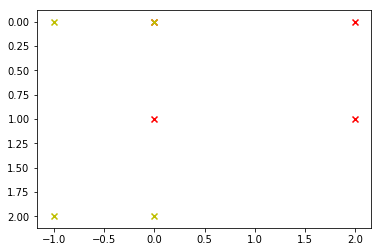

In [715]:
# pairs and pairs_prime represent 90° clockwise rotation
pairs = np.array([
    [0, 0],
    [0, 2],
    [1, 2],
    [1, 0]
])

pairs_prime = np.array([
    [0, 0],
    [2, 0],
    [2, -1],
    [0, -1]
])

plt.scatter(pairs[:, 1], pairs[:, 0], marker='x', c='r')
plt.scatter(pairs_prime[:, 1], pairs_prime[:, 0], marker='x', c='y')
plt.gca().invert_yaxis()

H = get_homography_matrix(pairs, pairs_prime)

H[np.abs(H) < 1e-10] = 0
print('H:')
print(H)

We know certain properties about H because the points given above represent a simple  clockwise rotation:
(See Matching lecture page 15)

- det([h11 h12; h21 h22]) = 1 (matlab syntax for 2x2 matrix)
- h31 = h32 = 0, h33 = 1 

In [716]:
assert int(np.linalg.det(H[:2, :2])) == 1
assert np.allclose(H[2], [0, 0, 1]) == True

Compute the projection of pairs using H and check that the projection is close to equal to pairs_prime:

In [717]:
ppp = H.dot(np.concatenate((
    pairs, np.ones((4, 1))
), axis = 1).T).T
assert np.allclose(pairs_prime, ppp[:, :2]) == True

## Testing on real image

In [718]:
import matplotlib.pyplot as plt
from harris import compute_harris_interest_points, patch_non_maxima_suppression
from utils import plot_side_by_side
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [744]:
image = plt.imread('edge.PNG') 
rotated_image = np.rot90(image, k=3)

## 1. Compute harris response, apply non-maxima suppression, threshold responses

In [745]:
harris = compute_harris_interest_points(image, harris_alpha = 0.05, blur_sigma = 2) # compute raw harris interest points
img = patch_non_maxima_suppression(harris, patch_shape=(5, 5), return_coords=False) # non-maxima suppression, no thresholding
y, x = np.where(img > img.mean()) #threshold responses
print(x.shape, y.shape)

(69,) (69,)


In [746]:
harris = compute_harris_interest_points(rotated_image, harris_alpha = 0.05, blur_sigma = 2) # compute raw harris interest points
img_prime = patch_non_maxima_suppression(harris, patch_shape=(5, 5), return_coords=False) # non-maxima suppression, no thresholding
y_p, x_p = np.where(img_prime > img_prime.mean()) #threshold responses
print(x_p.shape, y_p.shape)

(69,) (69,)


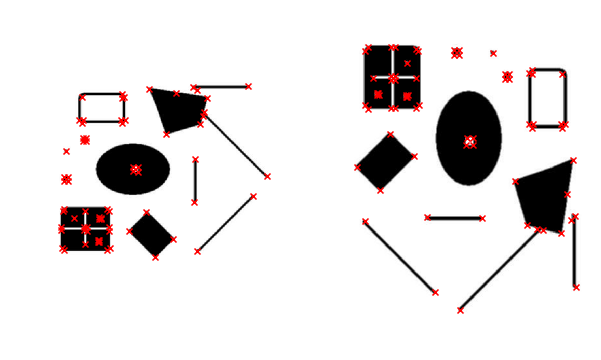

In [747]:
plt.figure(figsize=[10, 20])
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.scatter(x, y, marker='x', c='r')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(rotated_image)
plt.scatter(x_p, y_p, marker='x', c='r')
plt.axis('off')
plt.show()

In [748]:
to_grey = lambda img: 0.299 * img[:, :, 0] + 0.587 * img[:, :, 1] + 0.114 * img[:, :, 2] 

image = (to_grey(image) * 255).astype(np.uint8)
rotated_image = (to_grey(rotated_image) * 255).astype(np.uint8)

## 2. From interest points, fetch image patches and compute histogram for each patch

In [759]:
from descriptors import get_patch_histograms_from_interest_points_vec
_, bins = np.histogram(np.arange(255), bins=10)
descriptors_image, interest = get_patch_histograms_from_interest_points_vec(image, (y, x), bins=bins, patch_size=11)
descriptors_rotated_image, interest_rot = get_patch_histograms_from_interest_points_vec(rotated_image, (y_p, x_p), bins=bins, patch_size=11)

## 3. Nearest neighbor descriptor matching

In [750]:
from descriptors import match_descriptors_nn
inds = match_descriptors_nn(descriptors_image, descriptors_rotated_image)

points = np.array(interest).T
points_prime = np.array(interest_rot).T[inds]

## 4. Compute homography matrix and projection

In [758]:
H = get_homography_matrix(points, points_prime)

H_ref = np.array([[ 0, 1, 0],
                  [-1, 0, image.shape[0]], 
                  [ 0, 0, 1]]) # i.e. clockwise rotation + shift to the right of image.shape[0] pixels

print('\nGot: \n {}\n Expected: \n{}\n'.format(H.round().astype(int), H_ref))


Got: 
 [[  0   1   0]
 [ -1   0 488]
 [  0   0   1]]
 Expected: 
[[  0   1   0]
 [ -1   0 489]
 [  0   0   1]]



In [752]:
cat = np.concatenate((
    points, np.ones((points.shape[0], 1))
), axis = 1)

projected_points = H.dot(cat.T).T

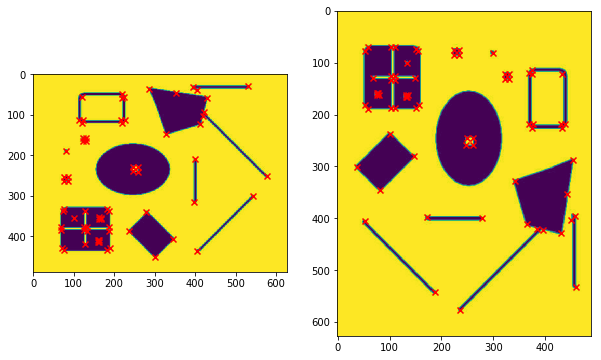

In [754]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.scatter(points[:, 1], points[:, 0], marker='x', c='r')
plt.subplot(1, 2, 2)
plt.imshow(rotated_image)
plt.scatter(projected_points[:, 1], projected_points[:, 0], marker='x', c='r')
plt.show()

## 5. Compute homography accuracy

In [755]:
from sklearn.metrics.pairwise import euclidean_distances

homography_distance = np.linalg.norm(projected_points[:, :2] - points_prime, axis = 1).mean() #mean euclidean distance between each pair of points
print('Accuracy: {}'.format(1 / (homography_distance + 1e-10)))

Accuracy: 5.3506885518204825
